In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
(training_set, validation_set, test_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:60%]', 'train[60%:80%]','train[80%:]'],
    with_info=True,
    as_supervised=True,
)


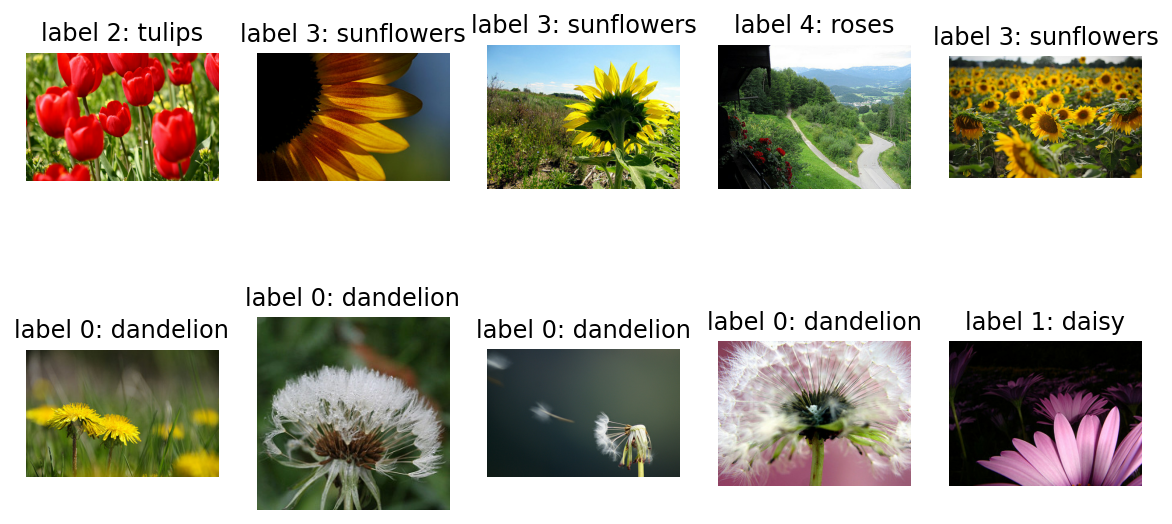

In [3]:
plt.figure(figsize=(10, 5))

get_label_name = dataset_info.features['label'].int2str

for idx, (image, label) in enumerate(training_set.take(10)):  
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [4]:
IMG_SIZE = 224
def format_example(image, label):
    image = tf.cast(image, tf.float32) 
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [5]:
train = training_set.map(format_example)
validation = validation_set.map(format_example)
test = test_set.map(format_example)

In [6]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       7

In [7]:
learning_rate = 1e-4
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [8]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
69/69 [==============================] - 9s 69ms/step - loss: 1.4016 - accuracy: 0.3847 - val_loss: 1.3324 - val_accuracy: 0.4646
Epoch 2/10
69/69 [==============================] - 4s 53ms/step - loss: 1.1248 - accuracy: 0.5332 - val_loss: 1.1177 - val_accuracy: 0.5409
Epoch 3/10
69/69 [==============================] - 4s 53ms/step - loss: 1.0401 - accuracy: 0.5822 - val_loss: 1.0665 - val_accuracy: 0.5368
Epoch 4/10
69/69 [==============================] - 4s 52ms/step - loss: 0.9562 - accuracy: 0.6240 - val_loss: 1.0830 - val_accuracy: 0.5599
Epoch 5/10
69/69 [==============================] - 4s 53ms/step - loss: 0.9177 - accuracy: 0.6499 - val_loss: 1.0072 - val_accuracy: 0.5940
Epoch 6/10
69/69 [==============================] - 4s 52ms/step - loss: 0.8461 - accuracy: 0.6653 - val_loss: 0.9679 - val_accuracy: 0.6131
Epoch 7/10
69/69 [==============================] - 4s 52ms/step - loss: 0.8147 - accuracy: 0.6898 - val_loss: 0.9613 - val_accuracy: 0.6213
Epoch 8/10
69

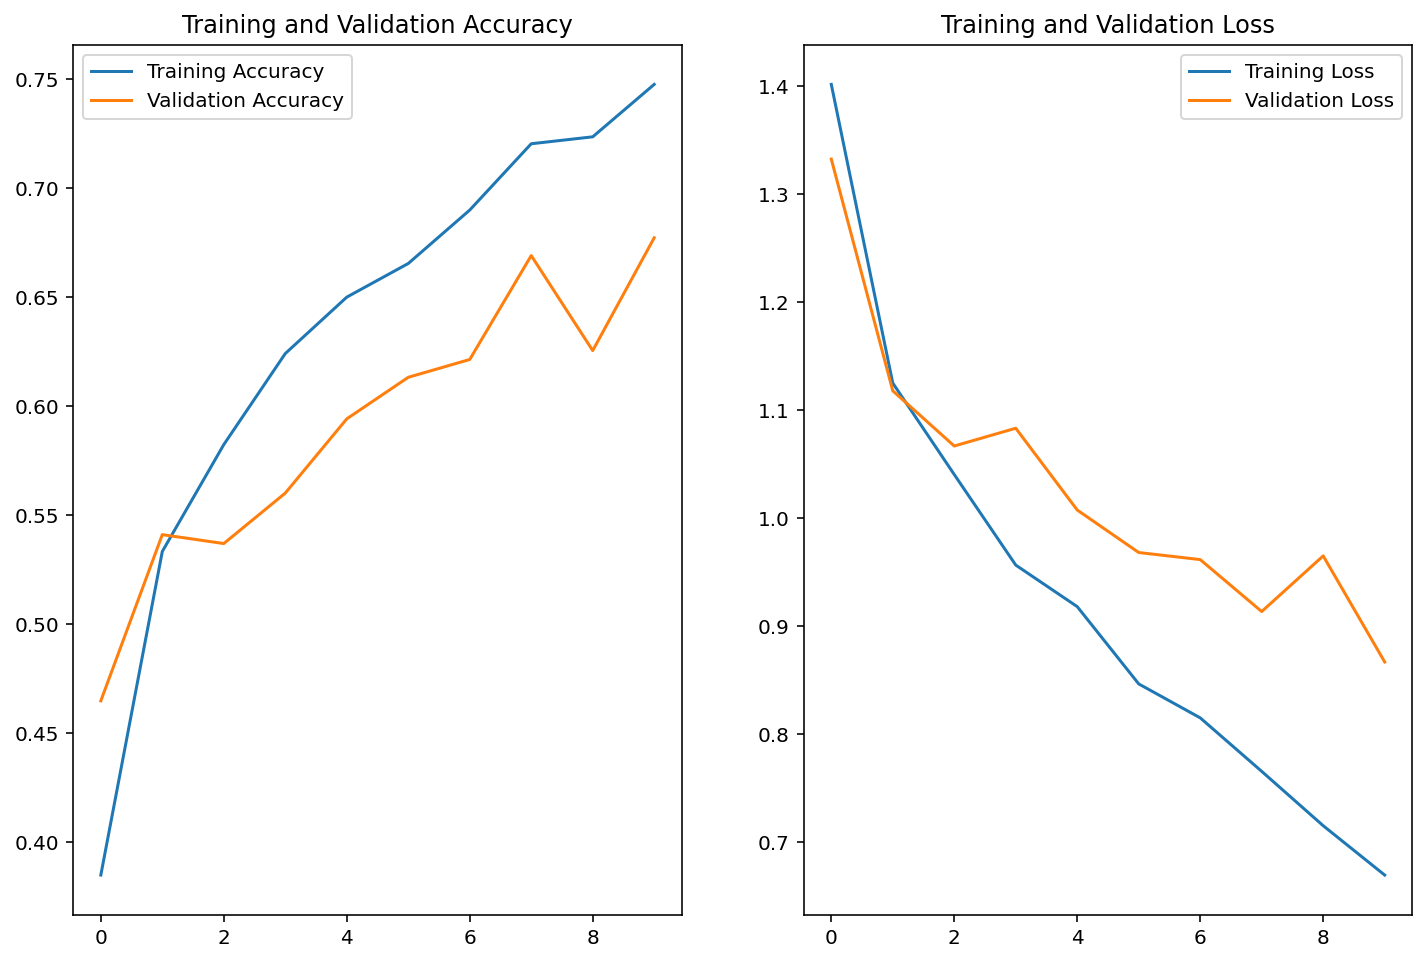

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [10]:
#from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2

#resnet= ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=5)
mobile = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet', classes=5)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#resnet_dense_layer = tf.keras.layers.Dense(512, activation='relu')
mobile_dense_layer = tf.keras.layers.Dense(1280, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

#resnet.trainable = False
mobile.trainable = False

mobile = tf.keras.Sequential([
  mobile,
  global_average_layer,
  mobile_dense_layer,
  prediction_layer
])

In [11]:
mobile.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 3,904,069
Trainable params: 1,646,085
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
base_learning_rate = 1e-3
mobile.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [13]:
EPOCHS = 10
history = mobile.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
69/69 [==============================] - 10s 96ms/step - loss: 0.5613 - accuracy: 0.8102 - val_loss: 0.4147 - val_accuracy: 0.8692
Epoch 2/10
69/69 [==============================] - 5s 63ms/step - loss: 0.1767 - accuracy: 0.9373 - val_loss: 0.4452 - val_accuracy: 0.8665
Epoch 3/10
69/69 [==============================] - 5s 60ms/step - loss: 0.0989 - accuracy: 0.9641 - val_loss: 0.4473 - val_accuracy: 0.8556
Epoch 4/10
69/69 [==============================] - 5s 61ms/step - loss: 0.0488 - accuracy: 0.9850 - val_loss: 0.4026 - val_accuracy: 0.8856
Epoch 5/10
69/69 [==============================] - 5s 62ms/step - loss: 0.0239 - accuracy: 0.9973 - val_loss: 0.4409 - val_accuracy: 0.8787
Epoch 6/10
69/69 [==============================] - 5s 61ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.4258 - val_accuracy: 0.8883
Epoch 7/10
69/69 [==============================] - 5s 63ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4431 - val_accuracy: 0.8774
Epoch 8/10
6

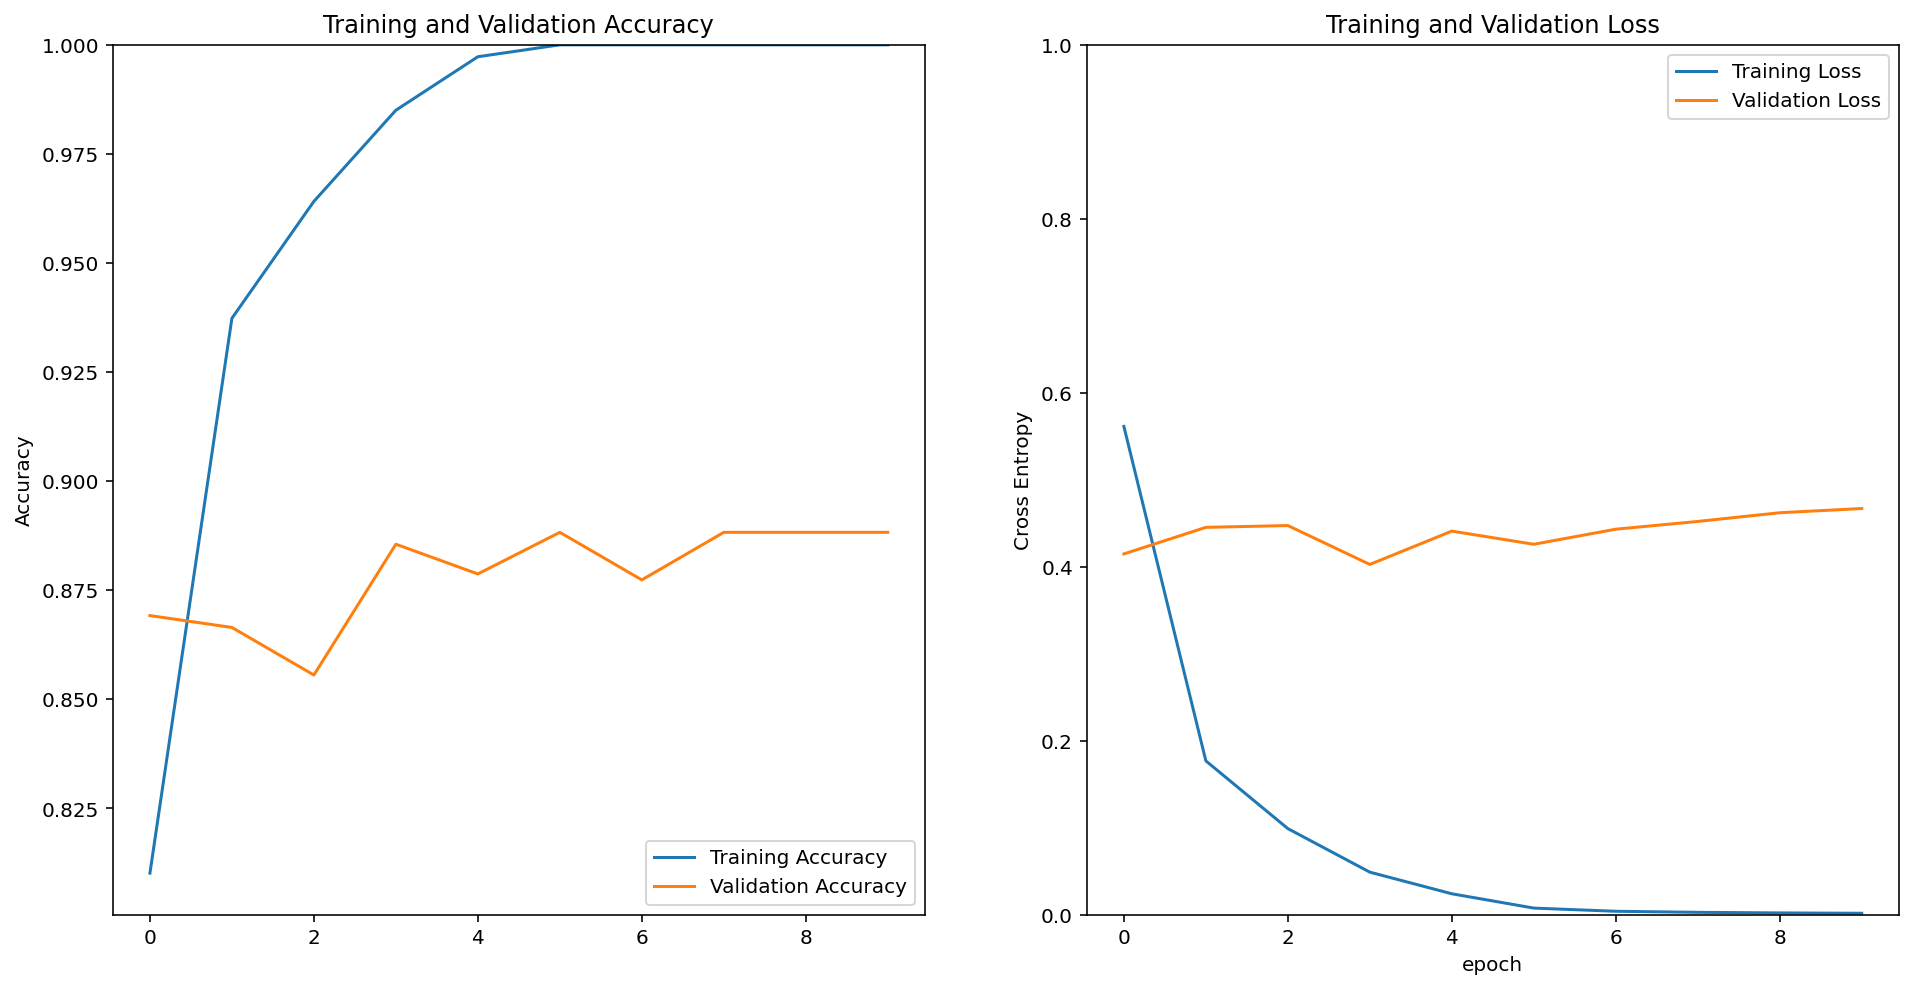

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions

array([4, 2, 2, 2, 0, 0, 2, 2, 3, 3, 2, 2, 1, 3, 2, 0, 0, 0, 1, 0, 2, 4,
       2, 2, 3, 0, 2, 1, 0, 2, 0, 2], dtype=int64)

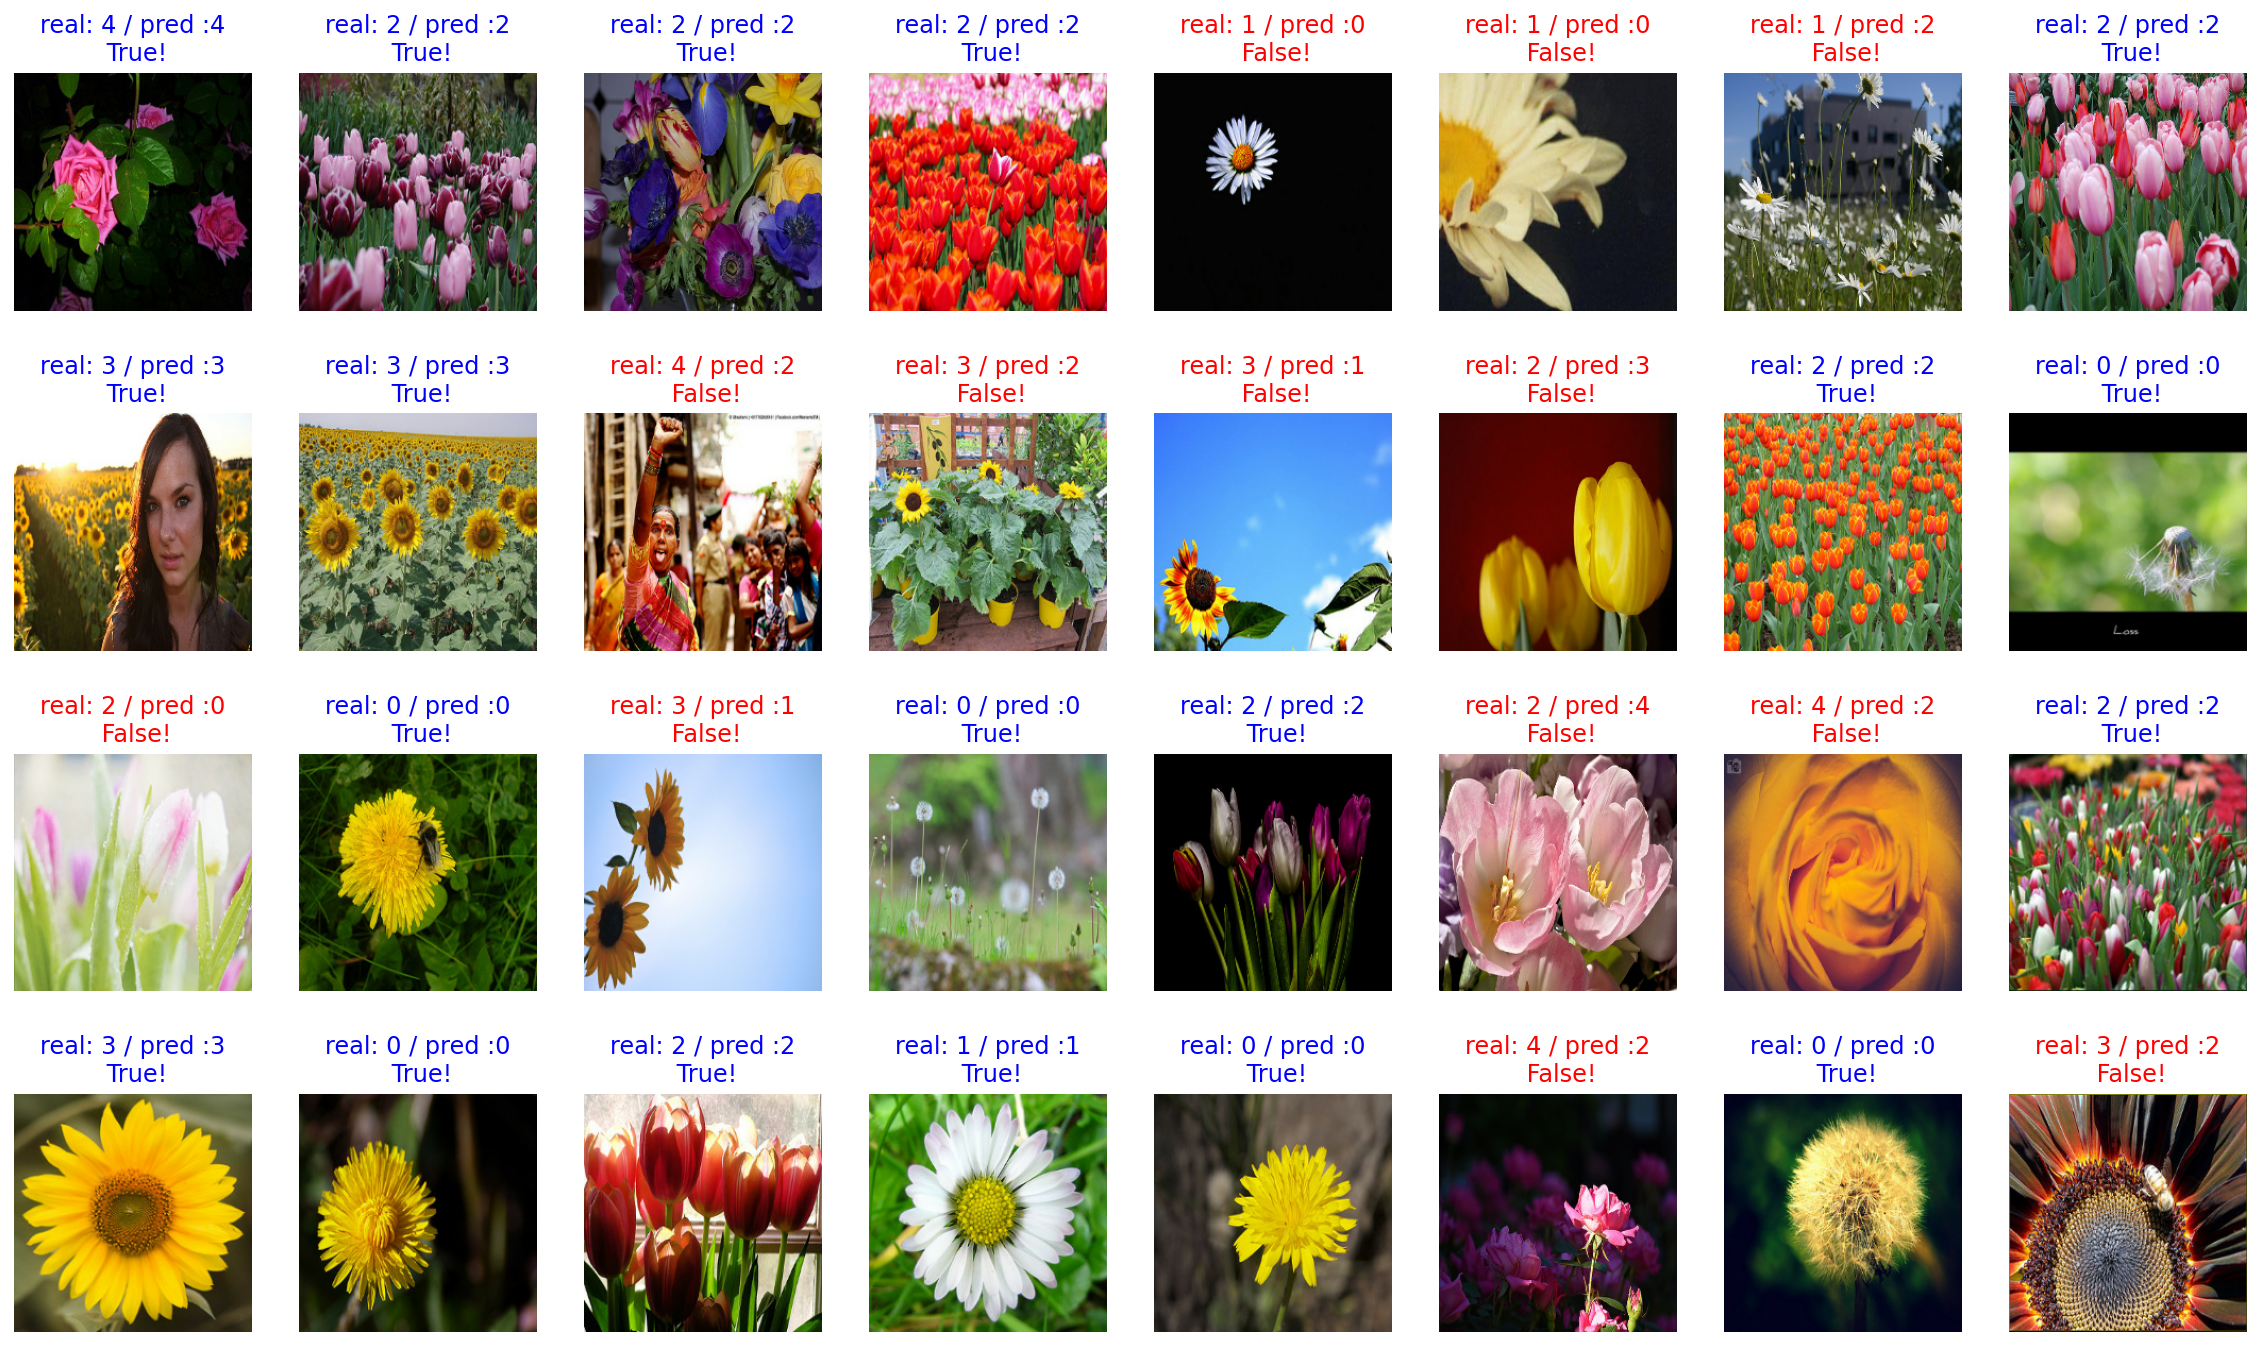

In [16]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')